In [1]:
import math

In practice, depth estimation using a stereo camera involves four steps and errors in any of these steps lead to an error in the depth estimation:
1. Undistortion: In this first step, radial and tangential lens distortions are removed mathematically. The outputs of this step are undistorted images.

We do not consider it in our model.

2. Rectification: This is the process of adjusting the angles and the distances between cameras to get a frontal parallel arrangement. This process is a crucial step in any stereo imaging algorithm. The outputs of this step are rectified and row-aligned images.

3. Correspondence: This is the process of finding common features in the left and right camera views. The output of this process is a disparity map, where the disparities are the differences in x-coordinates on the image plane.

4. Triangulation: In this process, the disparity map is converted to distances using the known geometric arrangement of the cameras. The output of this process is a depth map.

We do these steps considering the target to be one pixel.

Generally speaking, for this case we can use two approaches.

The first one is more general, when vision system is not binocular.
And another one is for the binocular case (ours).

#Stereo vision system model

##1. Intrinsic camera parameters

First, if we consider a calibrated camera (we know intrinsic patameter), then the calibration matrix **K**, containing the internal parameters of this camera (focal length, pixel dimensions, etc.), is known. 

It is used to convert from image coordinates in pixels to world coordinates on the camera matrix in millimeters, has the following entries:

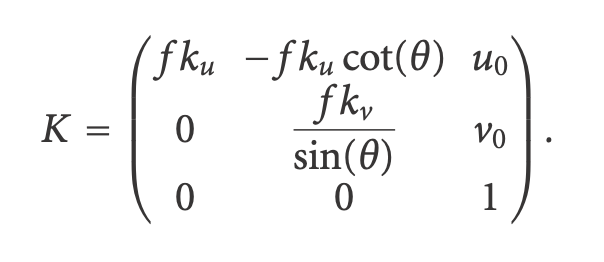

Here *f* is the focal length in millimeters, *k_u* and *k_v* are the number of pixels per millimeter (width and height, respectively, in our case is 1/0.0028), and *u_0*, *v_0* are the center of projection (in our case is (1024,540) for both cameras). If we let *α_u* and *α_v* be f*k_u and f*k_v respectively by multiplying the focal length *f* in mm by k, given in pixel/mm, this allows us to work in pixel units. The skew angle θ is almost always 90 degrees because modern camera-sensing elements are manufactured accurately <=> cot(90) is 0. Making these basic assumptions leaves us with four free intrinsic camera parameters α_u, α_v, u_0, and v_0. The calibration matrix K can therefore be rewritten in a much simpler form as

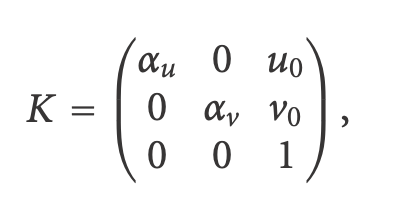

where the focal lengths *α_u* and *α_v* and principal point *u_0*, *v_0* are all quantified in pixels.

**We'll compute α_u basing on the camera patameters.**
**Also, we consider 1 pixel to be 0.0028 mm and the origins of the matrixes to be (1024, 540)**

##2. The essential matrix

The essential matrix can be considered the calibrated form of the fundamental matrix. It also encodes the epipolar geometry between two camera views and the epipolar constraint still holds given two points p1 and p2 in the camera matrix coordinate system:

* transposed(p_1) * E* p_2 = 0, where E = [T] × R.

1. T is the translational motion (vector) between the 3D camera positions.
2. R is the rotational motion (matrix). 

##**In our case T is (t, 0, 0) and R is identity matrix as camera matrix planes are the same!**
##**Thus, R1, R2 are identity matrixes, T1 is (0,0,0) and T2 has only first non-zero coordinate.**

Basing on said above let's consider binocular stereo vision system consisting of two cameras of the same specification, the same focal length, the same aperture and the same sensor area of the camera. Also, the left and right cameras remain in the same plane, thus ensuring that the horizontal axes of the left and right camera systems are on the same line and parallel to the imaging plane, as shown on the picture below. 


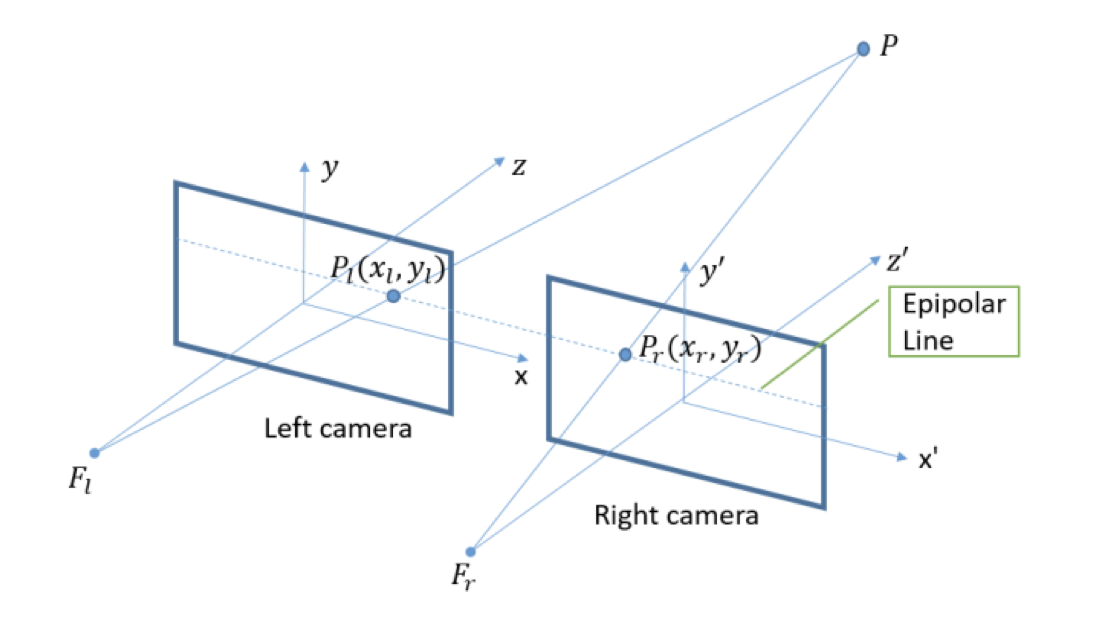

For this case, as I said previously, we can consider two approaches: general and for binocular system.

For general approach the steps are:

1. To compute camera matrixes P = K[ R | T ], where K, R, T are described above.
In our case P1 = K [ I | 0], P2 = K [ I | t]. We know K's and know R's and T's => we know P's.

2. Then to reconstruct the Fundamental Matrix F:
x' F x = 0, where x' and x are given projections to camera matrixes.
F = [P' C]_x P' pinv(P), for instance. C = (0, 1)
3. And after we perform straightforward triangulation basing on P1 and P2.

But I will describe simpler approach for the given case, as we can use just some analytic geometry to perform computations in binocular system case.

Here is the math model behind the further computations:

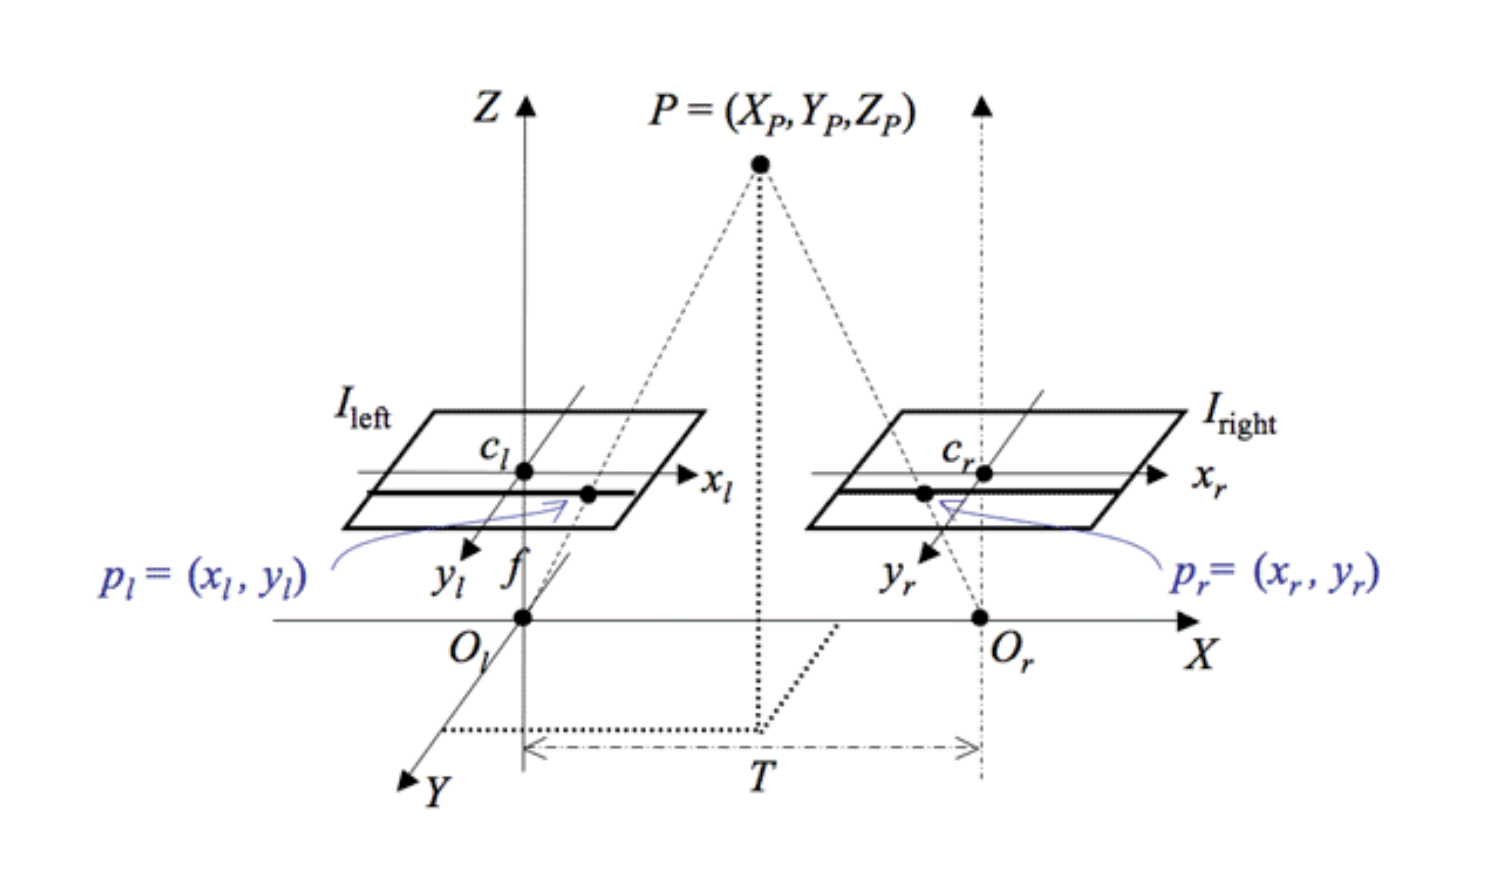

In [2]:
class Camera():
  def __init__(self, height: float, width: float, angle: float):
    self.height = height
    self.width = width
    self.angle = angle
    self.focal_length = None

  def set_focal_length(self, length: float):
    '''
    Setting the focal length
    '''
    self.focal_length = length

In [3]:
camera = Camera(1080.0, 2048.0, 78.0)

In [4]:
BASELINE = PIXELS_IN_METER = 100.0 / 0.00028 #basing on the experiments from attached papers

In [5]:
def get_focal_pixels() -> float: 
  '''
  Getting the focal distance in pixels basing on the matrix width and angle of view
  '''
  global camera
  
  return (camera.width * 0.5) / math.tan(camera.angle * 0.5 * math.pi/180.0)

def get_camera_disparity(x_1: float, x_2: float) -> float:
  '''
  The method returns the disparity basing on the given coordinates
  '''
  global camera

  return (x_1 - camera.width/2) - (x_2 - camera.width/2)

In [7]:
coordinates = {
    'x1': None,
    'y1': None,
    'x2': None,
    'y2': None
}

print('Enter coordinates for the left and right cameras:')

for key in coordinates.keys():
  print('{0} is '.format(key))
  t = int(input())
  coordinates[key] = t

print('Well done!')

Enter coordinates for the left and right cameras:
x1 is 
1024
y1 is 
540
x2 is 
0
y2 is 
540
Well done!


In [9]:
focal_length = get_focal_pixels()
camera.set_focal_length(focal_length)

print('Focal distance in pixels is {0} pixels.'.format(camera.focal_length))
print('Focal distance in mm is {0} mm.'.format(camera.focal_length*0.0028))

Focal distance in pixels is 1264.5346882918927 pixels.
Focal distance in mm is 3.5406971272172996 mm.


Thus, distance to object using scheme above can be obtained as Z = ( B * f ) / d, where 

1. *Z*: Distance to person (centimeters)
2. *B*: Base line (centimeters) 
3. *d*: Disparity (pixels)
4. *f*: Focal length (pixels)

Units of Z: 
* pixels * ( pixels / pixels ) = pixels

To get the distance in cm we need to multiply z-coordinate by 0.00028 (size of 1 pixel)



In [10]:
def get_distance(focal_length: float) -> float:
  '''
  Returns distance to point in pixels in Euclidean R\u00b3 space
  '''
  global BASELINE
  global coordinates
  disparity = get_camera_disparity(coordinates['x1'], coordinates['x2'])
  distance = BASELINE * focal_length / disparity

  return distance

def get_x_coordinate() -> float:
  '''
  Returns distance to point in pixels in Euclidean R\u00b3 space considering center of the middle camera to be origin
  '''
  global BASELINE
  global coordinates
  disparity = get_camera_disparity(coordinates['x1'], coordinates['x2'])
  x = BASELINE * (coordinates['x1']-camera.width/2) / disparity

  return x - BASELINE/2

In our case we consider the resulting y-coordinate (y-coordinate in the coordinate system of the middle camera) to be the same as y1 and y2.

In [12]:
print('The object coordinates in Euclidean space R\u00b3 are (x = {0}, z = {1}) in pixels (considering the central camera to be origin)'.format(get_x_coordinate(), get_distance(camera.focal_length)))
print('The distance to the object is {0} meters.'.format(get_distance(camera.focal_length)*0.0000028))
print('The distance from the center along X-axis is {0} metres.\n'.format(get_x_coordinate()*0.0000028))
print('\n')
print('That is clear that the y-coordinate of the point in the coordinate system of the central camera will be the same as y1 and y1.')

The object coordinates in Euclidean space R³ are (x = -178571.42857142858, z = 441034.6987625184) in pixels (considering the central camera to be origin)
The distance to the object is 1.2348971565350515 meters.
The distance from the center along X-axis is -0.5 metres.



That is clear that the y-coordinate of the point in the coordinate system of the central camera will be the same as y1 and y1.


To get the point x and z coordinates in the middle camera coordinates system we just need to do the x' = Px transformation, where again P is K[R|T], where T is (t/2, 0, 0), in comparison to (t,0,0) for the right camera for origin in the left camera and T = (0,0,0) for origin in the central camera, up to us. The R stays the same, identity matrix.